### KOREAN WON (KRW)

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
import numpy as np
from tensorflow.keras.regularizers import L2
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
warnings.filterwarnings('ignore')

### DATA LOADING

In [21]:
df = pd.read_csv(r'/content/KRW-2001.csv')
df

,Date,Close
0,12/1/2003 23:58:00,7.085116
1,12/2/2003 23:58:00,7.099471
2,12/3/2003 23:58:00,7.091019
3,12/4/2003 23:58:00,7.126057
4,12/5/2003 23:58:00,7.129288
...,...,...
6635,4/30/2024 23:58:00,11.744840
6636,5/1/2024 23:58:00,11.780220
6637,5/2/2024 23:58:00,11.791630
6638,5/3/2024 23:58:00,11.774580


### EDA

Text(0, 0.5, 'Korean Won')

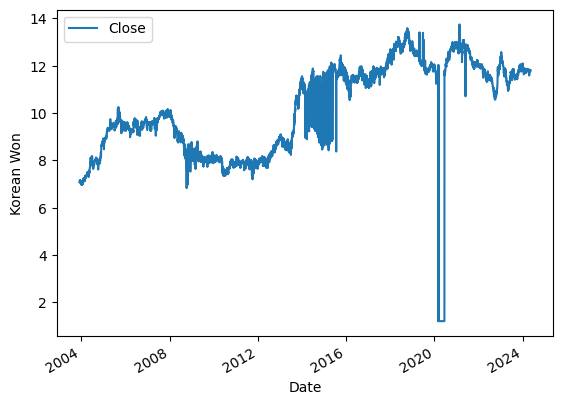

In [37]:
## PLOTTING THE DATA
df.columns = ['Date', 'Close']
df.Date = pd.to_datetime(df.Date)
df.set_index('Date',inplace=True)
df.plot()
plt.xlabel('Date')
plt.ylabel('Korean Won')

### FEATURE ENGINEERING

In [38]:
#splitting train and test
train=df[0:5000]
test=df[5000:]

train.head()

,Close
Date,
2003-12-01 23:58:00,7.085116
2003-12-02 23:58:00,7.099471
2003-12-03 23:58:00,7.091019
2003-12-04 23:58:00,7.126057
2003-12-05 23:58:00,7.129288


In [5]:
# Create a function to check stationarity

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [6]:
check_stationarity(df['Close'])

ADF Statistic: -3.934317
p-value: 0.001796
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


### Moving Average Model

In [7]:
predictions = []

window_size = 12
for i in range(len(test)):
    if i < window_size:
        moving_avg = train['Close'].mean()
    else:
        moving_avg = train['Close'].iloc[-window_size:].mean()

    predictions.append(moving_avg)

    train = pd.concat([train, test.iloc[[i]]], ignore_index=True)

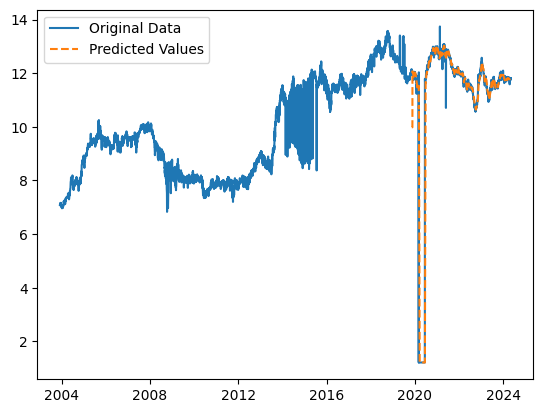

In [8]:
plt.plot(df['Close'], label='Original Data')
plt.plot(test.index, predictions, label='Predicted Values', linestyle='--')
plt.legend()
plt.show()

In [9]:
mae = mean_absolute_error(test.Close, predictions)
rmse = sqrt(mean_squared_error(test.Close, predictions))

# Menampilkan hasil
print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.1781462241660439
RMSE: 0.8073904022181578


### ARIMA

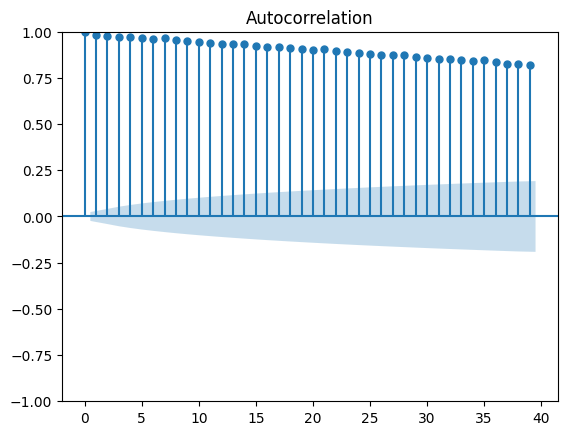

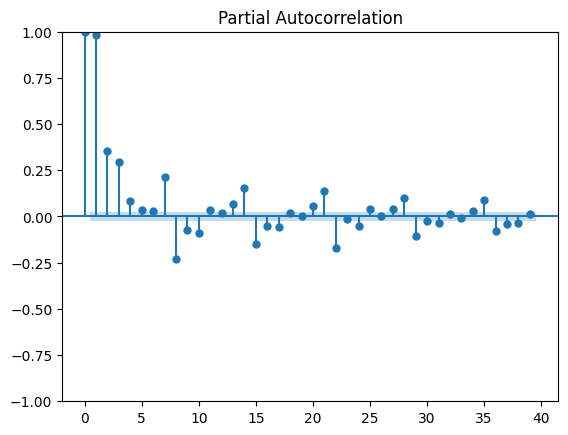

In [10]:
### ACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Close'])
plot_pacf(df['Close'])
plt.show()

- MA : 1,2,3,4,7,8
- AR : 0

>Potensi Model ARIMA :
ARIMA (0,0,1)
ARIMA (0,0,2)
ARIMA (0,0,3)
ARIMA (0,0,4)
ARIMA (0,0,7)
ARIMA (0,0,8)

In [ ]:
def find_best_model(data, num_p, num_d, num_q):
  df = pd.DataFrame() #We make a pandas dataframe to ease our work, you can use any way that makes you comfortable and work easly
  pdq = [[],[],[]] #This list for storing the combinations of p and q
  aic = [] # This list for storing aic value
  for p in range(num_p + 1): #plus one is to make the range up to num_p since python range only ranging from 0 to N-1
    for d in range(num_d + 1):
      for q in range(num_q + 1):
        # #if p!=0 and q!=0: #this logic will avoid (0,0) value which is not correct
        try: #Using exception to avoid the error while training the model with certain p and q value
          model = ARIMA(data, order=(p, d, q))
          result = model.fit()
          pdq[0].append(p)
          pdq[1].append(d)
          pdq[2].append(q)
          aic.append(result.aic)
        except:
          pass #If there is an error caused by the calculation, it will be skipped to the next iteration

  df['p'] = pdq[0]
  df['d'] = pdq[1]
  df['q'] = pdq[2]
  df['AIC'] = aic

  df.sort_values('AIC', inplace=True)

  return df.p.iloc[0], df.d.iloc[0], df.q.iloc[0], df.AIC.iloc[0], df

In [ ]:
find_best_model(df['Close'], 0, 0, 40)

(0,
 0,
 40,
 4844.163991669864,
     p  d   q            AIC
 40  0  0  40    4844.163992
 39  0  0  39    4855.072169
 38  0  0  38    4877.823414
 37  0  0  37    4917.402760
 36  0  0  36    4943.039687
 35  0  0  35    5005.040381
 34  0  0  34    5111.938705
 33  0  0  33    5138.458329
 32  0  0  32    5139.247125
 30  0  0  30    5229.283635
 27  0  0  27    5564.996997
 26  0  0  26    5582.170310
 25  0  0  25    5626.740664
 24  0  0  24    5656.792072
 23  0  0  23    5789.232343
 22  0  0  22    5845.228911
 21  0  0  21    5965.164287
 19  0  0  19    6331.040446
 18  0  0  18    6429.502405
 17  0  0  17    6486.177693
 15  0  0  15    6887.500044
 14  0  0  14    7299.432863
 31  0  0  31    7358.648347
 28  0  0  28    7525.326127
 13  0  0  13    7572.862449
 12  0  0  12    7579.452221
 11  0  0  11    7928.724037
 10  0  0  10    8304.048766
 9   0  0   9    8806.429319
 8   0  0   8    9653.974071
 7   0  0   7    9921.301880
 29  0  0  29   10783.369187
 6   0  0 

In [39]:
model_arima_0040 = ARIMA(df['Close'], order=(0, 0, 40))
result_model_arima_0040 = model_arima_0040.fit()

print('The AIC is ', result_model_arima_0040.aic)

The AIC is  4844.163971466259


In [40]:
df.head(10)

,Close
Date,
2003-12-01 23:58:00,7.085116
2003-12-02 23:58:00,7.099471
2003-12-03 23:58:00,7.091019
2003-12-04 23:58:00,7.126057
2003-12-05 23:58:00,7.129288
2003-12-08 23:58:00,7.154250
2003-12-09 23:58:00,7.158241
2003-12-10 23:58:00,7.079782
2003-12-11 23:58:00,7.067810


In [41]:
new_pred1 = result_model_arima_0040.predict(start="2003-12-1", end="2024-05-04", dynamic=False)
new_pred1 = pd.DataFrame(new_pred1)
new_pred1.columns = ['Close_predict']

all_dataset_with_pred1 = pd.concat([df, new_pred1], axis=1)
all_dataset_with_pred1.tail(50)

,Close,Close_predict
Date,,
2024-03-16 23:58:00,11.75856,11.736244
2024-03-17 23:58:00,11.75856,11.711714
2024-03-18 23:58:00,11.77169,11.703109
2024-03-19 23:58:00,11.76598,11.694791
2024-03-20 23:58:00,11.79724,11.708954
2024-03-21 23:58:00,11.77690,11.728808
2024-03-22 23:58:00,11.78606,11.702499
2024-03-23 23:58:00,11.78606,11.711302
2024-03-24 23:58:00,11.78606,11.707882


In [42]:
len_dataset = df.shape[0]
len_predict = len_dataset + 12


new_pred = result_model_arima_0040.predict(len_dataset, len_predict)
new_pred = pd.DataFrame(new_pred)
new_pred.columns = ['Close_forecast']

last_date = df.index.max()
date_range = pd.date_range(start=last_date, periods=13)
new_pred.index = date_range
# Menggabungkan prediksi dengan dataset asli

all_dataset_with_pred = pd.concat([all_dataset_with_pred1, new_pred], axis=1)

In [43]:
all_dataset_with_pred

,Close,Close_predict,Close_forecast
2003-12-01 23:58:00,7.085116,10.304688,NaN
2003-12-02 23:58:00,7.099471,7.217298,NaN
2003-12-03 23:58:00,7.091019,7.188731,NaN
2003-12-04 23:58:00,7.126057,7.165891,NaN
2003-12-05 23:58:00,7.129288,7.194743,NaN
...,...,...,...
2024-05-12 23:58:00,NaN,NaN,11.438092
2024-05-13 23:58:00,NaN,NaN,11.403041
2024-05-14 23:58:00,NaN,NaN,11.357730
2024-05-15 23:58:00,NaN,NaN,11.329659


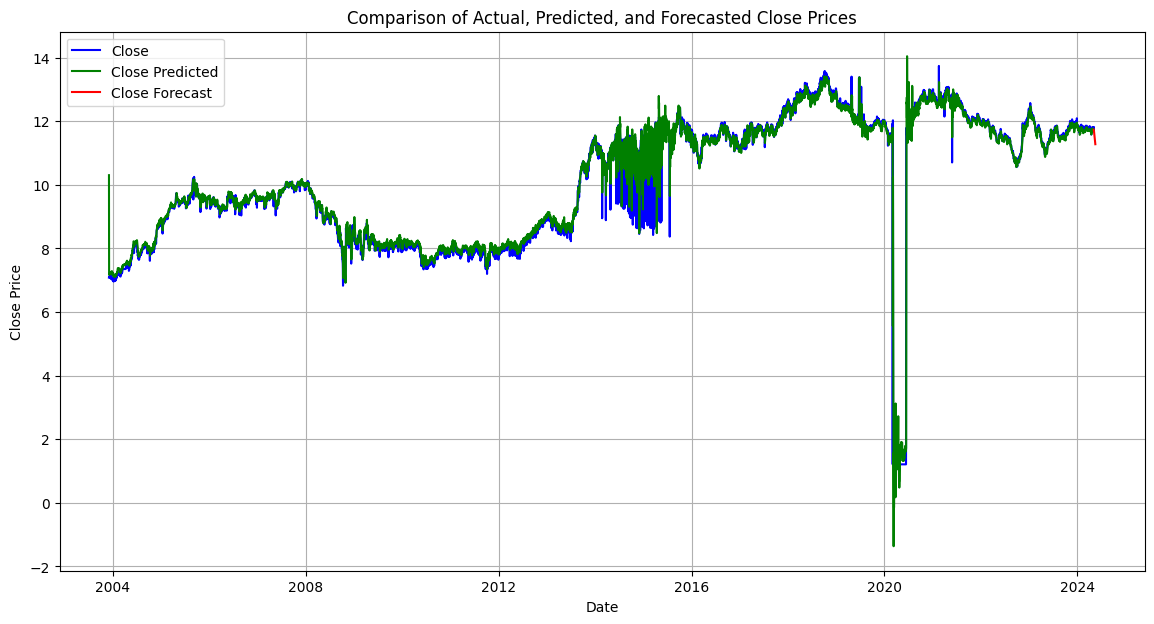

In [44]:
plt.figure(figsize=(14, 7))
plt.plot(all_dataset_with_pred.index, all_dataset_with_pred['Close'], label='Close', color='blue', linestyle='-')  # Data asli
plt.plot(all_dataset_with_pred.index, all_dataset_with_pred['Close_predict'], label='Close Predicted', color='green', linestyle='-')  # Data prediksi
plt.plot(all_dataset_with_pred.index, all_dataset_with_pred['Close_forecast'], label='Close Forecast', color='red', linestyle='-')  # Data forecast

plt.title('Comparison of Actual, Predicted, and Forecasted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
valid_data=all_dataset_with_pred.dropna(subset=['Close', 'Close_predict'])
valid_data

,Close,Close_predict,Close_forecast
2003-12-01 23:58:00,7.085116,10.304688,NaN
2003-12-02 23:58:00,7.099471,7.217298,NaN
2003-12-03 23:58:00,7.091019,7.188731,NaN
2003-12-04 23:58:00,7.126057,7.165891,NaN
2003-12-05 23:58:00,7.129288,7.194743,NaN
...,...,...,...
2024-04-30 23:58:00,11.744840,11.749956,NaN
2024-05-01 23:58:00,11.780220,11.696530,NaN
2024-05-02 23:58:00,11.791630,11.729436,NaN
2024-05-03 23:58:00,11.774580,11.717080,NaN


In [46]:
print('MAE test  : ', mean_absolute_error(valid_data['Close'], valid_data['Close_predict']))
print('RMSE test : ', np.sqrt(mean_squared_error(valid_data['Close'], valid_data['Close_predict'])))

MAE test  :  0.139718942937001
RMSE test :  0.348249073616545


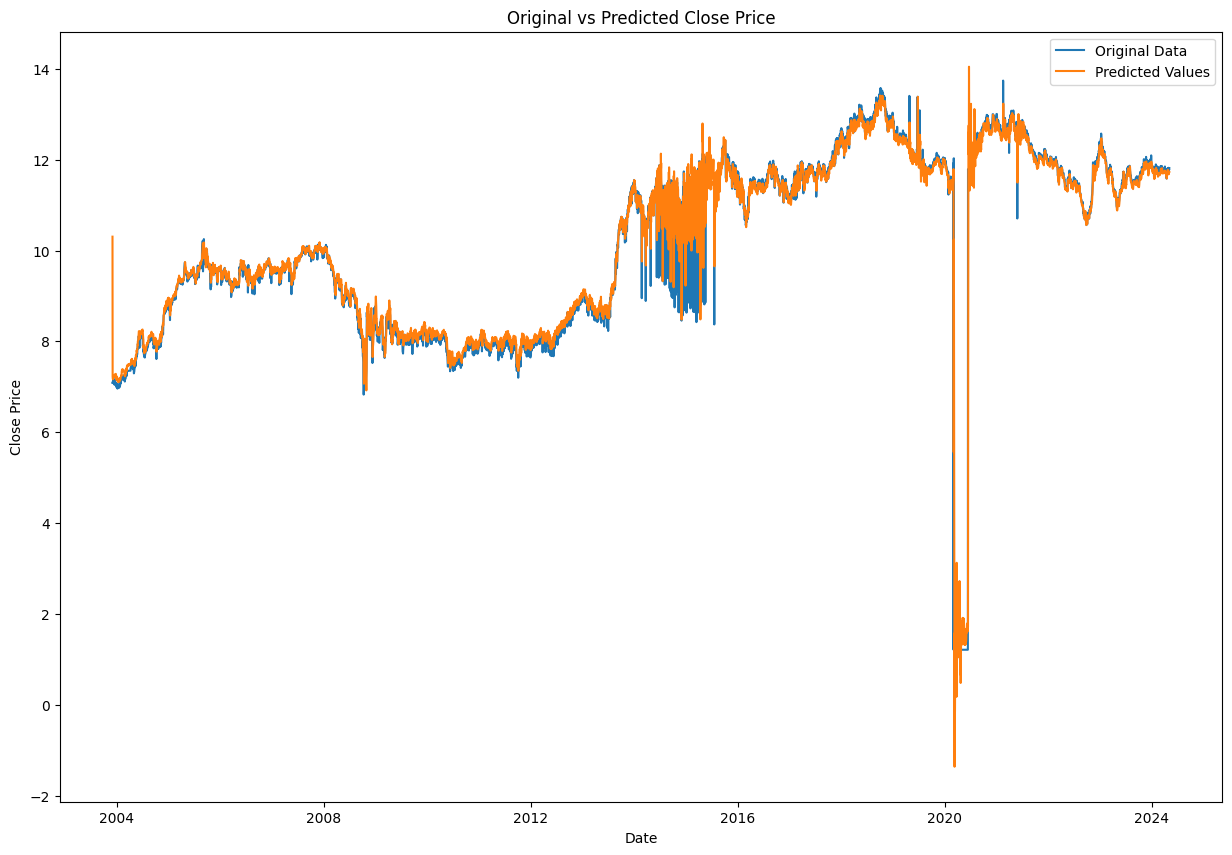

In [47]:
plt.figure(figsize=(15, 10))
plt.plot(df.index, df['Close'], label='Original Data')


# Plot predicted values overlapping the original data
plt.plot(all_dataset_with_pred.index, all_dataset_with_pred['Close_predict'], label='Predicted Values', linestyle='-')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Original vs Predicted Close Price')
plt.legend()
plt.show()

### LINEAR REGRESSION

In [48]:
df.head(10)

,Close
Date,
2003-12-01 23:58:00,7.085116
2003-12-02 23:58:00,7.099471
2003-12-03 23:58:00,7.091019
2003-12-04 23:58:00,7.126057
2003-12-05 23:58:00,7.129288
2003-12-08 23:58:00,7.154250
2003-12-09 23:58:00,7.158241
2003-12-10 23:58:00,7.079782
2003-12-11 23:58:00,7.067810


In [49]:
df_reg = df.copy()
df_reg = df_reg.drop(['Close'], axis=1)
df_reg['lag_5'] = df['Close'].shift(5)
df_reg['lag_4'] = df['Close'].shift(4)
df_reg['lag_3'] = df['Close'].shift(3)
df_reg['lag_2'] = df['Close'].shift(2)
df_reg['lag_1'] = df['Close'].shift(1)
df_reg['y'] = df['Close']

# Menampilkan dataset
df_reg

,lag_5,lag_4,lag_3,lag_2,lag_1,y
Date,,,,,,
2003-12-01 23:58:00,NaN,NaN,NaN,NaN,NaN,7.085116
2003-12-02 23:58:00,NaN,NaN,NaN,NaN,7.085116,7.099471
2003-12-03 23:58:00,NaN,NaN,NaN,7.085116,7.099471,7.091019
2003-12-04 23:58:00,NaN,NaN,7.085116,7.099471,7.091019,7.126057
2003-12-05 23:58:00,NaN,7.085116,7.099471,7.091019,7.126057,7.129288
...,...,...,...,...,...,...
2024-04-30 23:58:00,11.81079,11.784960,11.784970,11.762660,11.820370,11.744840
2024-05-01 23:58:00,11.78496,11.784970,11.762660,11.820370,11.744840,11.780220
2024-05-02 23:58:00,11.78497,11.762660,11.820370,11.744840,11.780220,11.791630


In [50]:
# Melakukan pengecekan nilai null pada dataset
df_reg.isnull().sum()

lag_5    5
lag_4    4
lag_3    3
lag_2    2
lag_1    1
y        0
dtype: int64

In [51]:
# Melakukan dropping nilai null pada data
df_reg.dropna(inplace=True)

# Mengecek hasil dropping nilai null
df_reg.isnull().sum()

lag_5    0
lag_4    0
lag_3    0
lag_2    0
lag_1    0
y        0
dtype: int64

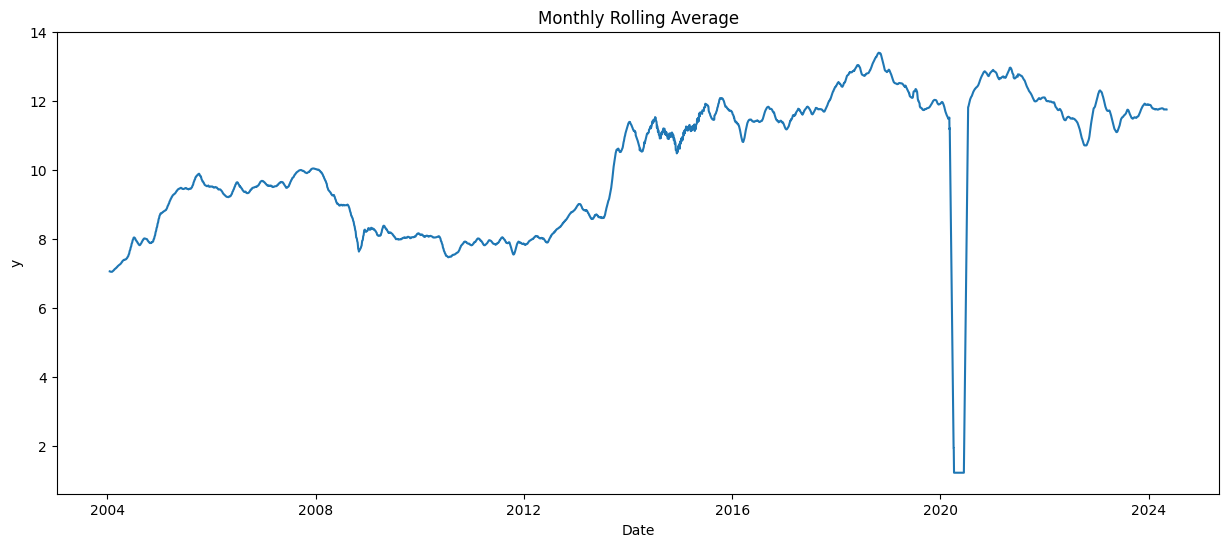

In [52]:
# Membuat visualisasi rolling per bulan
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = df_reg.index, y = df_reg["y"].rolling(30).mean(), data = df_reg, ax=ax)
ax.set_title("Monthly Rolling Average");

In [53]:
# Mengecek korelasi
df_reg.corr()

,lag_5,lag_4,lag_3,lag_2,lag_1,y
lag_5,1.000000,0.979757,0.974379,0.974280,0.970017,0.965963
lag_4,0.979757,1.000000,0.979751,0.974372,0.974273,0.970008
lag_3,0.974379,0.979751,1.000000,0.979746,0.974365,0.974266
lag_2,0.974280,0.974372,0.979746,1.000000,0.979740,0.974358
lag_1,0.970017,0.974273,0.974365,0.979740,1.000000,0.979735
y,0.965963,0.970008,0.974266,0.974358,0.979735,1.000000


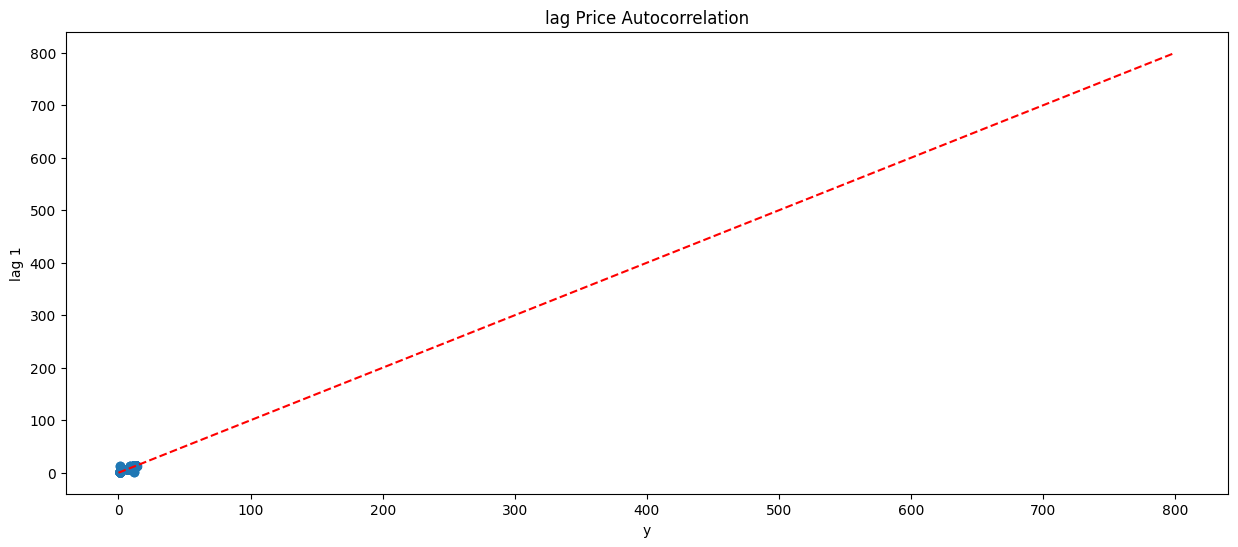

In [54]:
# Membuat visualisasi korelasi antara lag 0 dan lag 1
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(x=df_reg["y"], y=df_reg["lag_1"])
ax.plot([0,800],[0,800],linestyle="--", color="red")
plt.xlabel("y")
plt.ylabel("lag 1")
plt.title("lag Price Autocorrelation");

In [55]:
# Split the data menjadi fitur dan target
target = "y"
y = df_reg[target]
X = df_reg.drop(columns= target)

#Split the data into train and test sets
cutoff = int(len(X) * 0.8)
X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

<Axes: xlabel='Date'>

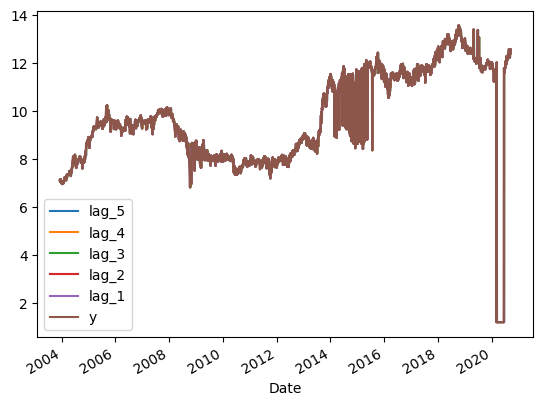

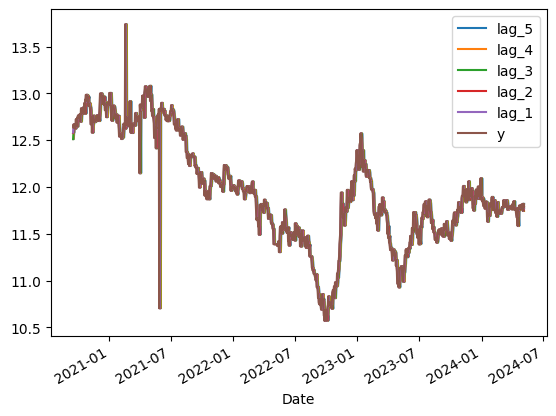

In [56]:
# Plotting data
df_reg[:len(X_train)].plot()
df_reg[len(X_train):].plot()

In [57]:
y_pred_baseline = [y_train.mean()] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean Close Prices:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean Close Prices: 9.9
Baseline MAE: 1.74


In [58]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [59]:
training_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae = mean_absolute_error(y_test, model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 0.13
Test MAE: 0.05


In [60]:
df_pred_test = pd.DataFrame(
             {
             "y_test": y_test,
             "y_pred": model.predict(X_test)
             }
)
df_pred_test.head()

,y_test,y_pred
Date,,
2020-09-16 23:58:00,12.63750,12.533803
2020-09-17 23:58:00,12.67051,12.577142
2020-09-18 23:58:00,12.64827,12.606990
2020-09-19 23:58:00,12.64827,12.617494
2020-09-20 23:58:00,12.64827,12.626645


In [61]:
import plotly.express as px

fig = px.line(df_pred_test, labels= {"value": "Close Price"}, title = "Linear Regression Model: Actual Prices vs. Predicted Prices.")
fig.show()

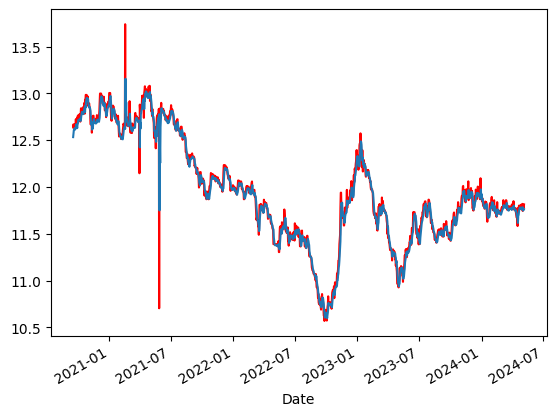

In [62]:
import matplotlib.pyplot as plt

df_pred_test['y_test'].plot(color='red')
plt.plot(df_pred_test['y_pred'])

In [63]:
print('MAE test  : ', mean_absolute_error(df_pred_test['y_test'], df_pred_test['y_pred']))
print('RMSE test : ', np.sqrt(mean_squared_error(df_pred_test['y_test'], df_pred_test['y_pred'])))

MAE test  :  0.05087028613992326
RMSE test :  0.09924086248025778


### LSTM

In [64]:
tf.random.set_seed(100)
tf.keras.backend.clear_session()

# Define the model_thb
model_thb = Sequential([
    LSTM(units=512, return_sequences=True, input_shape=(X_train.shape[1],1), kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    LSTM(units=512, return_sequences=True, kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    LSTM(units=512, kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    Dense(units=128, activation='relu', kernel_regularizer=L2(0.001)),
    Dropout(0.2),
    Dense(units=1, kernel_regularizer=L2(0.001))
])

model_thb.compile(optimizer='adam', loss='mae', metrics=['mae']) # Notice the change here

# Display model_thb summary
model_thb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 512)            1052672   
                                                                 
 dropout (Dropout)           (None, 5, 512)            0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 512)            2099200   
                                                                 
 dropout_1 (Dropout)         (None, 5, 512)            0         
                                                                 
 lstm_2 (LSTM)               (None, 512)               2099200   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               6

In [65]:
history_thb = model_thb.fit(X_train, y_train, epochs= 100, batch_size= 32)

Epoch 1/100
166/166 [==============================] - 19s 79ms/step - loss: 2.1621 - mae: 1.2827
Epoch 2/100
166/166 [==============================] - 13s 79ms/step - loss: 1.1821 - mae: 0.8011
Epoch 3/100
166/166 [==============================] - 13s 80ms/step - loss: 1.0592 - mae: 0.8198
Epoch 4/100
166/166 [==============================] - 13s 78ms/step - loss: 0.9314 - mae: 0.7567
Epoch 5/100
166/166 [==============================] - 13s 80ms/step - loss: 0.8688 - mae: 0.7311
Epoch 6/100
166/166 [==============================] - 13s 79ms/step - loss: 0.8317 - mae: 0.7166
Epoch 7/100
166/166 [==============================] - 13s 80ms/step - loss: 0.8277 - mae: 0.7287
Epoch 8/100
166/166 [==============================] - 13s 79ms/step - loss: 0.7944 - mae: 0.7065
Epoch 9/100
166/166 [==============================] - 13s 79ms/step - loss: 0.7880 - mae: 0.7086
Epoch 10/100
166/166 [==============================] - 13s 80ms/step - loss: 0.7584 - mae: 0.6854
Epoch 11/100
166/16

In [66]:
predictions_lstm = model_thb.predict(X_test)

42/42 [==============================] - 3s 30ms/step


In [67]:
print('MAE test  : ', mean_absolute_error(y_test, predictions_lstm))
print('RMSE test : ', np.sqrt(mean_squared_error(y_test, predictions_lstm)))

MAE test  :  0.4059307732540266
RMSE test :  0.42382233095769395


### MODEL EVALUATION

In [68]:
all_reports = {}
def performance_report(all_reports, y_test, y_pred_test, name):
  score_reports = {
      'MAE test' : mean_absolute_error(y_test, y_pred_test),
      'RMSE test' : np.sqrt(mean_squared_error(y_test, y_pred_test)),
  }
  all_reports[name] = score_reports
  return all_reports

In [69]:
# Menambahkan hasil Logistic Regression ke dalam dictionary
all_reports = performance_report(all_reports, df_pred_test['y_test'], df_pred_test['y_pred'], 'Linear Regression')
pd.DataFrame(all_reports)

,Linear Regression
MAE test,0.050870
RMSE test,0.099241


In [70]:
# Menambahkan hasil Moving Average ke dalam dictionary
all_reports = performance_report(all_reports, test['Close'], predictions, 'Moving Average')
pd.DataFrame(all_reports)

,Linear Regression,Moving Average
MAE test,0.050870,0.178146
RMSE test,0.099241,0.807390


In [71]:
# Mengambil data untuk report arima
arima_report = all_dataset_with_pred.copy()
arima_report = arima_report.dropna(subset=['Close', 'Close_predict'])
arima_report

,Close,Close_predict,Close_forecast
2003-12-01 23:58:00,7.085116,10.304688,NaN
2003-12-02 23:58:00,7.099471,7.217298,NaN
2003-12-03 23:58:00,7.091019,7.188731,NaN
2003-12-04 23:58:00,7.126057,7.165891,NaN
2003-12-05 23:58:00,7.129288,7.194743,NaN
...,...,...,...
2024-04-30 23:58:00,11.744840,11.749956,NaN
2024-05-01 23:58:00,11.780220,11.696530,NaN
2024-05-02 23:58:00,11.791630,11.729436,NaN
2024-05-03 23:58:00,11.774580,11.717080,NaN


In [72]:
# Menambahkan hasil ARIMA ke dalam dictionary
all_reports = performance_report(all_reports, arima_report['Close'], arima_report['Close_predict'], 'ARIMA')
pd.DataFrame(all_reports)

,Linear Regression,Moving Average,ARIMA
MAE test,0.050870,0.178146,0.139719
RMSE test,0.099241,0.807390,0.348249


In [73]:
# Menambahkan hasil LSTM ke dalam dictionary
all_reports = performance_report(all_reports, y_test, predictions_lstm, 'LSTM')
pd.DataFrame(all_reports)

,Linear Regression,Moving Average,ARIMA,LSTM
MAE test,0.050870,0.178146,0.139719,0.405931
RMSE test,0.099241,0.807390,0.348249,0.423822


### FURTHER ANALYSIS

Untuk evaluasi model. Kita melihat nilai MAE dan RMSE yang paling kecil. Dimana dapat terlihat bahwa dari nilai MAE dan RMSE model Linear Regression adalah model terbaik dalam memprediksi kurs dari Korean WON

In [74]:
# Melihat data hasil
hasil = df_pred_test.copy()
hasil.head()

,y_test,y_pred
Date,,
2020-09-16 23:58:00,12.63750,12.533803
2020-09-17 23:58:00,12.67051,12.577142
2020-09-18 23:58:00,12.64827,12.606990
2020-09-19 23:58:00,12.64827,12.617494
2020-09-20 23:58:00,12.64827,12.626645


In [75]:
# Melihat min dan max dari data menggunakan describe
hasil.describe()

,y_test,y_pred
count,1327.000000,1327.000000
mean,11.960357,11.944098
std,0.572024,0.563065
min,10.569230,10.598887
25%,11.572560,11.557916
50%,11.868350,11.847112
75%,12.457560,12.443491
max,13.740330,13.157764


In [76]:
jum_lower_data = hasil[(hasil['y_pred']<hasil['y_test'])].count()
print(f"Jumlah data y_pred lebih kecil dari y_test asli adalah {jum_lower_data[0]}")
print("Keseluruhan jumlah data adalah ", len(hasil))
print("Persentase jumlah data lebih kecil adalah ", (jum_lower_data[0]/len(hasil))*100, "%")

Jumlah data y_pred lebih kecil dari y_test asli adalah 813
Keseluruhan jumlah data adalah  1327
Persentase jumlah data lebih kecil adalah  61.26601356443104 %


Terlihat bahwa presentase jumlah data lebih kecil adalah 61% dari data asli. Sehingga dapat disarankan untuk pengguna kalkulator untuk menyiapkan uang yang lebih dari hasil prediksi kami  

### MODEL SAVING

In [ ]:
model_pkl_file = "bea_cukai_krw_linreg.pkl"

with open(model_pkl_file, 'wb') as file:
    pickle.dump(model, file)